# Underfitting or Overfitting?
When we compare the training and validation errors, we want to be mindful of two common situations: First, we want
to watch out for cases when our training error and validation error are both substantial but there is a little gap between
them. If the model is unable to reduce the training error, that could mean that our model is too simple (i.e., insufficiently
expressive) to capture the pattern that we are trying to model. Moreover, since the generalization gap between our training
and validation errors is small, we have reason to believe that we could get away with a more complex model. This
phenomenon is known as underfitting.

On the other hand, as we discussed above, we want to watch out for the cases when our training error is significantly lower
than our validation error, indicating severe overfitting. Note that overfitting is not always a bad thing. With deep learning
especially, it’s well known that the best predictive models often perform far better on training data than on holdout data.

Ultimately, we usually care more about the validation error than about the gap between the training and validation errors.
Whether we overfit or underfit can depend both on the complexity of our model and the size of the available training
datasets, two topics that we discuss below.

## Model Complexity 

To illustrate some classical intuition about overfitting and model complexity, we given an example using polynomials.
Given training data consisting of a single feature x and a corresponding real-valued label y, we try to find the polynomial
of degree d

$$y=\sum_{i=0}^d\ W^ix^i$$

to estimate the labels y. This is just a linear regression problem where our features are given by the powers of x, the wi
given the model’s weights, and the bias is given by w0 since x
0 = 1 for all x. Since this is just a linear regression problem,
we can use the squared error as our loss function.
A higher-order polynomial function is more complex than a lower order polynomial function, since the higher-order polynomial has more parameters and the model function’s selection range is wider. Fixing the training data set, higher-order
polynomial functions should always achieve lower (at worst, equal) training error relative to lower degree polynomials.
In fact, whenever the data points each have a distinct value of x, a polynomial function with degree equal to the number
of data points can fit the training set perfectly. We visualize the relationship between polynomial degree and under- vs
over-fitting below.

## Data Set Size

The other big consideration to bear in mind is the dataset size. Fixing our model, the fewer samples we have in the
training dataset, the more likely (and more severely) we are to encounter overfitting. As we increase the amount of
training data, the generalization error typically decreases. Moreover, in general, more data never hurts. For a fixed task
and data distribution, there is typically a relationship between model complexity and dataset size. Given more data, we
might profitably attempt to fit a more complex model. Absent sufficient data, simpler models may be difficult to beat. For
many tasks, deep learning only outperforms linear models when many thousands of training examples are available. In part, the current success of deep learning owes to the current abundance of massive datasets due to internet companies,
cheap storage, connected devices, and the broad digitization of the economy.

## Polynomial Regression
We can now explore these concepts interactively by fitting polynomials to data. To get started we’ll import our usual
packages.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

## Generating Data Sets

First we need data. Given x, we will use the following cubic polynomial to generate the labels on training and test data:

$$y=5+1.2x-3.4\frac{x^2}{2!}+5.6\frac{x^3}{3!}+ E where E-N(0,0.1)$$

The noise term ϵ obeys a normal distribution with a mean of 0 and a standard deviation of 0.1. We’ll synthesize 100
samples each for the training set and test set

In [6]:
max_degree=20
n_train,n_test=100,100

In [7]:
poly_features=torch.zeros(20,200)
true_w=torch.zeros(max_degree)
true_w[0:4] = torch.tensor([5, 1.2, -3.4, 5.6])
features = torch.randn(size=(n_train + n_test, 1))
x_list=torch.arange(max_degree)
x_list.float()
features=features.reshape(1,-1)

for i in range(1,max_degree):
    
    poly_features[i] = torch.pow(features,i)
    
print(features[:,4])
print(poly_features[:,4])

tensor([0.1063])
tensor([0.0000e+00, 1.0626e-01, 1.1290e-02, 1.1997e-03, 1.2747e-04, 1.3544e-05,
        1.4392e-06, 1.5292e-07, 1.6249e-08, 1.7265e-09, 1.8345e-10, 1.9493e-11,
        2.0712e-12, 2.2008e-13, 2.3385e-14, 2.4848e-15, 2.6402e-16, 2.8054e-17,
        2.9809e-18, 3.1673e-19])


For optimization, we typically want to avoid very large values of gradients, losses, etc. This is why the monomials stored
in poly_features are rescaled from x

It allows us to avoid very large values for large exponents i. Factorials
are implemented in Gluon using the Gamma function, where n! = Γ(n + b 1).
Take a look at the first 2 samples from the generated data set. The value 1 is technically a feature, namely the constant
feature corresponding to the bias

In [15]:
from scipy.special import factorial
ok=torch.arange(1,(max_degree) + 1).reshape((1, -1))

dr=factorial(ok)

poly_features = poly_features.double() /dr.t()

labels = torch.matmul(true_w.double(),poly_features)

poly_features = poly_features.type(torch.FloatTensor)

labels = labels.type(torch.FloatTensor)

labels += torch.randn(200)*0.5



### Defining, Training and Testing Model
We first define the plotting functionsemilogy, where the y axis makes use of the logarithmic scale

Since we will be attempting to fit the generated dataset using models of varying complexity, we insert the model definition
into the fit_and_plot function. The training and testing steps involved in polynomial function fitting are similar to
those previously described in softmax regression

In [16]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
legend=None, figsize=(3.5, 2.5)):
   
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [17]:
def fit_and_plot(train_features,train_labels,test_features,test_labels,no_inputs):
    class LinearRegressionModel(torch.nn.Module): 
  
        def __init__(self): 
            super(LinearRegressionModel, self).__init__() 
            self.linear = torch.nn.Linear(no_inputs, 1)  
  
        def forward(self, x): 
            y_pred = self.linear(x) 
            return y_pred 
    
    model = LinearRegressionModel() 
    criterion = torch.nn.MSELoss(reduction='sum') 
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
    train_ls,test_ls=[],[]

   
   
   
    train_labels=train_labels.reshape(-1,1)
    train_ds=TensorDataset(train_features,train_labels)
    batch_size=10
    train_dl=DataLoader(train_ds,batch_size,shuffle=True)


    
    test_labels=test_labels.reshape(-1,1)
    for ep in range(100):
        for xb,yb in train_dl: 
  
        
            pred_y = model(xb) 
  
    
            loss = criterion(pred_y, yb) 
            
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()
           
            
        
        predytr=model(train_features)
        train_ls.append((criterion(predytr,train_labels)).mean())
        predyts=model(test_features)
        test_ls.append((criterion(predyts,test_labels)).mean())    
    
    
    print('final epoch:train loss',train_ls[-1],'test Loss',test_ls[-1])
    semilogy(range(1,ep+2), train_ls,'epoch','loss',range(1,ep+2),test_ls,['train','test'])
  



### Third-order Polynomial Function Fitting (Normal)

We will begin by first using a third-order polynomial function with the same order as the data generation function. The
results show that this model’s training error rate when using the testing data set is low. The trained model parameters are
also close to the true values w = [5, 1.2, −3.4, 5.6].


final epoch:train loss tensor(31.9768, grad_fn=<MeanBackward0>) test Loss tensor(26.1930, grad_fn=<MeanBackward0>)


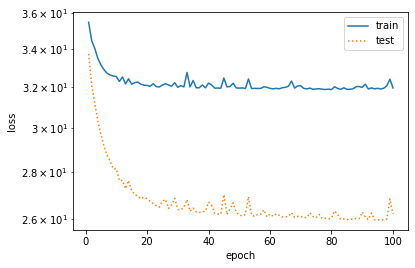

In [18]:
poly_features_t=poly_features.t()
fit_and_plot(train_features=poly_features_t[:100,0:4],train_labels=labels[:100],test_features=poly_features_t[100:,0:4],test_labels=labels[100:],no_inputs=4)




## Linear Function Fitting
Let’s take another look at linear function fitting. After the decline in the early epoch, it becomes difficult to further
decrease this model’s training error rate. After the last epoch iteration has been completed, the training error rate is
still high. When used to fit non-linear patterns (like the third-order polynomial function here) linear models are liable to
underfit.

final epoch:train loss tensor(32.0082, grad_fn=<MeanBackward0>) test Loss tensor(26.3281, grad_fn=<MeanBackward0>)


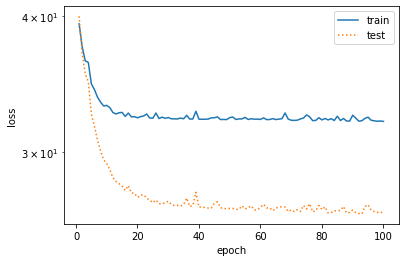

In [19]:
fit_and_plot(train_features=poly_features_t[:100,0:3],train_labels=labels[:100],test_features=poly_features_t[100:,0:3],test_labels=labels[100:],no_inputs=3)



## Insufficient Training(Overfitting)
Now let’s try to train the model using a polynomial of too high degree. Here, there is insufficient data to learn that the
higher-degree coefficients should have values close to zero. As a result, our overly-complex model is far too susceptible
to being influenced by noise in the training data. Of course, our training error will now be low (even lower than if we had
the right model!) but our test error will be high.
Try out different model complexities (n_degree) and training set sizes (n_subset) to gain some intuition of what is
happening.


final epoch:train loss tensor(32.0402, grad_fn=<MeanBackward0>) test Loss tensor(26.4105, grad_fn=<MeanBackward0>)


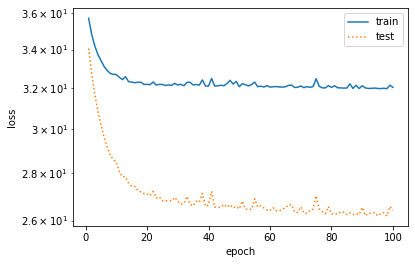

In [20]:
fit_and_plot(train_features=poly_features_t[1:100,0:20],train_labels=labels[1:100],test_features=poly_features_t[100:,0:20],test_labels=labels[100:],no_inputs=20)


## Summary
• Since the generalization error rate cannot be estimated based on the training error rate, simply minimizing the
training error rate will not necessarily mean a reduction in the generalization error rate. Machine learning models
need to be careful to safeguard against overfitting such as to minimize the generalization error.

• A validation set can be used for model selection (provided that it isn’t used too liberally).

• Underfitting means that the model is not able to reduce the training error rate while overfitting is a result of the
model training error rate being much lower than the testing data set rate.

• We should choose an appropriately complex model and avoid using insufficient training samples

## Exercises

1. Can you solve the polynomial regression problem exactly? 
Hint - use linear algebra.

2. Model selection for polynomials
    
    • Plot the training error vs. model complexity (degree of the polynomial). 
    What do you observe?
    
    • Plot the test error in this case.
    
    • Generate the same graph as a function of the amount of data?

3. What happens if you drop the normalization of the polynomial features x
i by 1/i!. 
Can you fix this in some other
way?

4. What degree of polynomial do you need to reduce the training error to 0?